In [243]:
import dill
import pandas as pd
import numpy as np
import altair as alt


In [193]:
joiner='&yearlist='
yearquery=joiner[1:]+joiner.join(['231','345'])
yearquery

'yearlist=231&yearlist=345'

In [245]:
years = [2017,2018,2016,2019]
histnum='IncomeTaxesPaidNet'
histbase='TaxableIncome'
tic='aapl'

t=dill.load(open('t.pkl','rb'))
tag2label=dill.load(open('tag2label.pkl','rb'))
tickers=pd.read_table('tickers.txt')
tickers=tickers.set_index('cik')
    

if tic=='':
    ticik=None
else:
    try:
        ticik=tickers[tickers['ticker']==tic].index.values[0]
    except:
        ticik=None

setselect=(t.index.get_level_values('year').isin(years) & (t.index.get_level_values('cik')==ticik))

# Create dataset to be inserted in Altair
if histbase!=None:
    data_hist=t.loc[setselect,[('value',histnum),('value',histbase),('month',histnum),('month',histbase)]].copy()
    data_hist[('','hist_match')]=(t[('month',histnum)]==t[('month',histbase)])
    data_hist=data_hist.drop([('month',histnum),('month',histbase)],axis=1)    
if histbase==None:
    data_hist=t.loc[setselect,list(set([('value',histnum),('month',histnum)]))].copy()
    data_hist[('','hist_match')]=t[('month',histnum)].notnull()
    data_hist=data_hist.drop([('month',histnum)],axis=1)

# Drop 0 level and add company name:
data_hist=data_hist.droplevel(axis=1,level=0)
data_hist=data_hist.merge(dill.load(open('sic_codes.pkl','rb')),how='left',left_index=True,right_index=True)
data_hist=data_hist.droplevel(axis=0,level=0)

# Define variables to be charted:
h1=tag2label[histnum]
if histbase!=None:
    h2=tag2label[histbase]
hy='Fiscal Years'
if histbase!=None:
    hvar=h1+' Per '+h2
else:
    hvar=h1
data_hist.loc[data_hist['hist_match'],h1]=data_hist[histnum]
if histbase!=None:
    data_hist.loc[data_hist['hist_match'],h2]=data_hist[histbase]
data_hist['yearc']=data_hist.index.get_level_values('year').astype('str')
data_hist.loc[data_hist['hist_match'],hy]=data_hist['yearc']

# Sort years:
data_hist=data_hist.sort_values('year',ascending=True)

#Define trendline variable:
if histbase!=None:
    data_hist[hvar]=data_hist[h1]/data_hist[h2]
else:
    data_hist[hvar]=data_hist[h1]
data_hist.loc[data_hist['hist_match']==0,hvar]=None

#Add string formatted labels:
hvarlabel='Value'
if histbase!=None:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "{:,.2f}".format(x))
elif data_hist[hvar].mean()>1:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "${:,.0f}".format(x))
else:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x:100*x).map(lambda x: "{:,.2f}%".format(x))

# ALTAIR Chart

hscale='linear'

trend = alt.Chart(data_hist, title=data_hist['name'].values[0],width=600, height=200).mark_line().encode(
    alt.Y(f'{hvar}:Q',scale=alt.Scale(type=hscale)),
    x = hy
)
points = alt.Chart(data_hist,width=600, height=200).mark_point(filled=True,size=100).encode(
    alt.Y(f'{hvar}',scale=alt.Scale(type=hscale)),
    x = hy,tooltip=[hvarlabel,hy]
)
plot=trend+points
plot.to_json()
f'trends.json?h1={h1}&h2={h2}&{yearquery}&ticker={tic}'
plot

alt.LayerChart(...)

In [183]:
# Load needed files
t=dill.load(open('t.pkl','rb'))
tag2label=dill.load(open('tag2label.pkl','rb'))
tickers=pd.read_table('tickers.txt')
tickers=tickers.set_index('cik')
    
ticik=tickers[tickers['ticker']==tic].index.values[0]
setselect=(t.index.get_level_values('year').isin(years) & (t.index.get_level_values('cik')==ticik))
    

In [185]:
if histbase!=None:
    data_hist=t.loc[setselect,list(set([('value',histnum),('value',histbase),('month',histnum),('month',histbase)]))].copy()
    data_hist[('','hist_match')]=(t[('month',histnum)]==t[('month',histbase)])
    data_hist=data_hist.drop([('month',histnum),('month',histbase)],axis=1)    
if histbase==None:
    data_hist=t.loc[setselect,list(set([('value',histnum),('month',histnum)]))].copy()
    data_hist[('','hist_match')]=t[('month',histnum)].notnull()
    data_hist=data_hist.drop([('month',histnum)],axis=1)

data_hist=data_hist.droplevel(axis=1,level=0)
data_hist=data_hist.merge(dill.load(open('sic_codes.pkl','rb')),how='left',left_index=True,right_index=True)
data_hist=data_hist.droplevel(axis=0,level=0)

# Define variables to be aggregated:
h1=tag2label[histnum]
if histbase!=None:
    h2=tag2label[histbase]
hy='Fiscal Years (histogram)'
if histbase!=None:
    hvar=h1+' Per '+h2
else:
    hvar=h1

data_hist.loc[data_hist['hist_match'],h1]=data_hist[histnum]
if histbase!=None:
    data_hist.loc[data_hist['hist_match'],h2]=data_hist[histbase]
data_hist['yearc']=data_hist.index.get_level_values('year').astype('str')
data_hist.loc[data_hist['hist_match'],hy]=data_hist['yearc']

data_hist=data_hist.sort_values('year',ascending=False)


In [189]:
gg=data_hist.groupby('year').agg({h1:'sum','hist_match':'sum','sic':'first','name':'first'})
gg

,"Income Taxes Paid, Net",hist_match,sic,name
year,,,,
2016,1.044400e+10,True,3571.0,APPLE INC
2017,1.159100e+10,True,3571.0,APPLE INC
2018,1.041700e+10,True,3571.0,APPLE INC
2019,1.526300e+10,True,3571.0,APPLE INC


In [153]:
if histbase!=None:
    data_hist[hvar]=data_hist[h1]/data_hist[h2]
else:
    data_hist[hvar]=data_hist[h1]
data_hist.loc[data_hist['hist_match']==0,hvar]=None

hvarlabel='Histogram value'
if histbase!=None:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "{:,.2f}".format(x))
elif data_hist[hvar].mean()>1:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "${:,.0f}".format(x))
else:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x:100*x).map(lambda x: "{:,.2f}%".format(x))


In [174]:
hscale='linear'

trend = alt.Chart(data_hist, title=data_hist['name'].values[0],width=600, height=200).mark_line().encode(
    alt.Y(f'{hvar}:Q',scale=alt.Scale(type=hscale)),
    x = hy
)
points = alt.Chart(data_hist,width=600, height=200).mark_point(filled=True,size=100).encode(
    alt.Y(f'{hvar}',scale=alt.Scale(type=hscale)),
    x = hy,tooltip=[hvarlabel,hy]
)
trend+points

alt.LayerChart(...)

In [181]:

data_hist.shape


(4, 11)

In [190]:
data_hist


,TaxableIncome,IncomeTaxesPaidNet,hist_match,name,sic,"Income Taxes Paid, Net",Taxable Income,yearc,Fiscal Years (histogram)
year,,,,,,,,,
2019,6.573700e+10,1.526300e+10,True,APPLE INC,3571.0,1.526300e+10,6.573700e+10,2019,2019
2018,7.290300e+10,1.041700e+10,True,APPLE INC,3571.0,1.041700e+10,7.290300e+10,2018,2018
2017,6.408900e+10,1.159100e+10,True,APPLE INC,3571.0,1.159100e+10,6.408900e+10,2017,2017
2016,6.137200e+10,1.044400e+10,True,APPLE INC,3571.0,1.044400e+10,6.137200e+10,2016,2016


In [228]:
data_hist.iloc[:,3]

year
2018    AMAZON COM INC
2019    AMAZON COM INC
Name: name, dtype: object

In [224]:
    # Load needed files
    t=dill.load(open('t.pkl','rb'))
    tag2label=dill.load(open('tag2label.pkl','rb'))
    tickers=pd.read_table('tickers.txt')
    tickers=tickers.set_index('cik')

    # Sample values:
    years=[2018,2019]
    histnum='DomesticIncomeTaxExpenseBenefit'
    histbase='TaxableIncome'   
    tic='amzn'
    
    # Year selection - checklists:
#    years = request.args.getlist('yearlist')
#    years=[int(y) for y in years]         

    # Variable selection
#    histnum=request.args.get('h1','DomesticIncomeTaxExpenseBenefit')
#    histbase=request.args.get('h2',None)
#    if histbase=='None':
#        histbase=None
#    tic=request.args.get('ticker',None) #User input

    #Obtain cik for selected ticker:
    if tic=='':
        ticik=None
    else:
        try:
            ticik=tickers[tickers['ticker']==tic].index.values[0]
        except:
            ticik=None

    setselect=(t.index.get_level_values('year').isin(years) & (t.index.get_level_values('cik')==ticik))

    # Create dataset to be inserted in Altair
    if histbase!=None:
        data_hist=t.loc[setselect,[('value',histnum),('value',histbase),('month',histnum),('month',histbase)]].copy()
        data_hist[('','hist_match')]=(t[('month',histnum)]==t[('month',histbase)])
        data_hist=data_hist.drop([('month',histnum),('month',histbase)],axis=1)    
    if histbase==None:
        data_hist=t.loc[setselect,list(set([('value',histnum),('month',histnum)]))].copy()
        data_hist[('','hist_match')]=t[('month',histnum)].notnull()
        data_hist=data_hist.drop([('month',histnum)],axis=1)

    # Drop 0 level and add company name:
    data_hist=data_hist.droplevel(axis=1,level=0)
    data_hist=data_hist.merge(dill.load(open('sic_codes.pkl','rb')),how='left',left_index=True,right_index=True)
    data_hist=data_hist.droplevel(axis=0,level=0)
    
    # Define variables to be charted:
    h1=tag2label[histnum]
    if histbase!=None:
        h2=tag2label[histbase]
    hy='Fiscal Years'
    if histbase!=None:
        hvar=h1+' Per '+h2
    else:
        hvar=h1
    data_hist.loc[data_hist['hist_match'],h1]=data_hist[histnum]
    if histbase!=None:
        data_hist.loc[data_hist['hist_match'],h2]=data_hist[histbase]
    data_hist['yearc']=data_hist.index.get_level_values('year').astype('str')
    data_hist.loc[data_hist['hist_match'],hy]=data_hist['yearc']

    # Sort years:
    data_hist=data_hist.sort_values('year',ascending=True)

    #Define trendline variable:
    if histbase!=None:
        data_hist[hvar]=data_hist[h1]/data_hist[h2]
    else:
        data_hist[hvar]=data_hist[h1]
    data_hist.loc[data_hist['hist_match']==0,hvar]=None

    #Add string formatted labels:
    hvarlabel='Trendline value'
    if histbase!=None:
        data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "{:,.2f}".format(x))
    elif data_hist[hvar].mean()>1:
        data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "${:,.0f}".format(x))
    else:
        data_hist[hvarlabel]=data_hist[hvar].map(lambda x:100*x).map(lambda x: "{:,.2f}%".format(x))

    # ALTAIR Chart
    
    trend = alt.Chart(data_hist, title=data_hist['name'].values[0],width=600, height=200).mark_line().encode(
        alt.Y(f'{hvar}:Q',scale=alt.Scale(type='linear')),
        x = hy
    )
    points = alt.Chart(data_hist,width=600, height=200).mark_point(filled=True,size=100).encode(
        alt.Y(f'{hvar}',scale=alt.Scale(type='linear')),
        x = hy,tooltip=[hvarlabel,hy]
    )
    plot=trend+points
plot.to_json()

'{\n  "$schema": "https://vega.github.io/schema/vega-lite/v4.8.1.json",\n  "config": {\n    "view": {\n      "continuousHeight": 300,\n      "continuousWidth": 400\n    }\n  },\n  "data": {\n    "name": "data-03fd40aae2b11f371f887b0927af674e"\n  },\n  "datasets": {\n    "data-03fd40aae2b11f371f887b0927af674e": [\n      {\n        "Domestic Income Tax Expense (Benefit)": 436000000.0,\n        "Domestic Income Tax Expense (Benefit) Per Taxable Income": 0.03871769825059941,\n        "DomesticIncomeTaxExpenseBenefit": 436000000.0,\n        "Fiscal Years": "2018",\n        "Taxable Income": 11261000000.0,\n        "TaxableIncome": 11261000000.0,\n        "Trendline value": "0.04",\n        "hist_match": true,\n        "name": "AMAZON COM INC",\n        "sic": 5961.0,\n        "yearc": "2018"\n      },\n      {\n        "Domestic Income Tax Expense (Benefit)": 1076000000.0,\n        "Domestic Income Tax Expense (Benefit) Per Taxable Income": 0.07698912421293647,\n        "DomesticIncomeTaxEx

In [215]:
    #Define trendline variable:
    if histbase!=None:
        datahs[hvar]=datahs[h1]/datahs[h2]
    else:
        datahs[hvar]=datahs[h1]
    datahs.loc[datahs['hist_match']==0,hvar]=None
    
        #Add string formatted labels:
    hvarlabel='Trendline value'
    if histbase!=None:
        datahs[hvarlabel]=datahs[hvar].map(lambda x: "{:,.2f}".format(x))
    elif datahs[hvar].mean()>1:
        datahs[hvarlabel]=datahs[hvar].map(lambda x: "${:,.0f}".format(x))
    else:
        datahs[hvarlabel]=datahs[hvar].map(lambda x:100*x).map(lambda x: "{:,.2f}%".format(x))



In [219]:
    trend = alt.Chart(datahs, title=datahs['name'].values[0],width=600, height=200).mark_line().encode(
        alt.Y(f'{hvar}:Q',scale=alt.Scale(type='linear')),
        x = hy
    )
#    points = alt.Chart(datahs,width=600, height=200).mark_point(filled=True,size=100).encode(
#        alt.Y(f'{hvar}',scale=alt.Scale(type='linear')),
#        x = hy,tooltip=[hvarlabel,hy]
#    )

In [221]:
datahs

,Domestic Income Tax Expense (Benefit),Taxable Income,hist_match,sic,name,Domestic Income Tax Expense (Benefit) Per Taxable Income,Trendline value
year,,,,,,,
2018,4.360000e+08,1.126100e+10,True,5961.0,AMAZON COM INC,0.038718,0.04
2019,1.076000e+09,1.397600e+10,True,5961.0,AMAZON COM INC,0.076989,0.08


In [232]:
# Get request to read in form entries
yearlist=['2018','2019']
h1='DomesticIncomeTaxExpenseBenefit'
h2='TaxableIncome'   
tic='amzn'

# Define vars for json external file method
tag2label=dill.load(open('tag2label.pkl','rb'))
h1n=tag2label[h1]
if h2!=None:
    h2n=tag2label[h2]
    hvar=h1n+' Per '+h2n
else:
    hvar=h1n
hvar='DomesticIncomeTaxExpenseBenefit'
hy='Fiscal Years'

# Build yearlist query string
joiner='&yearlist='
yearquery=joiner[1:]+joiner.join(yearlist)


In [241]:
# Load needed files
t=dill.load(open('t.pkl','rb'))
tag2label=dill.load(open('tag2label.pkl','rb'))
tickers=pd.read_table('tickers.txt')
tickers=tickers.set_index('cik')

# Sample values:
years=[2018,2019]
histnum='DomesticIncomeTaxExpenseBenefit'
histbase=None    
tic='amzn'

# Year selection - checklists:
#    years = request.args.getlist('yearlist')
#    years=[int(y) for y in years]         

# Variable selection
#    histnum=request.args.get('h1','DomesticIncomeTaxExpenseBenefit')
#    histbase=request.args.get('h2',None)
#    if histbase=='None':
#        histbase=None
#    tic=request.args.get('ticker',None) #User input

#Obtain cik for selected ticker:
if tic=='':
    ticik=None
else:
    try:
        ticik=tickers[tickers['ticker']==tic].index.values[0]
    except:
        ticik=None

setselect=(t.index.get_level_values('year').isin(years) & (t.index.get_level_values('cik')==ticik))

# Create dataset to be inserted in Altair
if histbase!=None:
    data_hist=t.loc[setselect,[('value',histnum),('value',histbase),('month',histnum),('month',histbase)]].copy()
    data_hist[('','hist_match')]=(t[('month',histnum)]==t[('month',histbase)])
    data_hist=data_hist.drop([('month',histnum),('month',histbase)],axis=1)    
if histbase==None:
    data_hist=t.loc[setselect,list(set([('value',histnum),('month',histnum)]))].copy()
    data_hist[('','hist_match')]=t[('month',histnum)].notnull()
    data_hist=data_hist.drop([('month',histnum)],axis=1)

# Drop 0 level and add company name:
data_hist=data_hist.droplevel(axis=1,level=0)
data_hist=data_hist.merge(dill.load(open('sic_codes.pkl','rb')),how='left',left_index=True,right_index=True)
data_hist=data_hist.droplevel(axis=0,level=0)

# Define variables to be charted:
h1=tag2label[histnum]
if histbase!=None:
    h2=tag2label[histbase]
hy='Fiscal Years'
if histbase!=None:
    hvar=h1+' Per '+h2
else:
    hvar=h1
data_hist.loc[data_hist['hist_match'],h1]=data_hist[histnum]
if histbase!=None:
    data_hist.loc[data_hist['hist_match'],h2]=data_hist[histbase]
data_hist['yearc']=data_hist.index.get_level_values('year').astype('str')
data_hist.loc[data_hist['hist_match'],hy]=data_hist['yearc']

# Sort years:
data_hist=data_hist.sort_values('year',ascending=True)

#Define trendline variable:
if histbase!=None:
    data_hist[hvar]=data_hist[h1]/data_hist[h2]
else:
    data_hist[hvar]=data_hist[h1]
data_hist.loc[data_hist['hist_match']==0,hvar]=None

#Add string formatted labels:
hvarlabel='Trendline value'
if histbase!=None:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "{:,.2f}".format(x))
elif data_hist[hvar].mean()>1:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "${:,.0f}".format(x))
else:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x:100*x).map(lambda x: "{:,.2f}%".format(x))

xx=data_hist.to_json(orient='records')

In [242]:
xx

'[{"DomesticIncomeTaxExpenseBenefit":436000000.0,"hist_match":true,"name":"AMAZON COM INC","sic":5961.0,"Domestic Income Tax Expense (Benefit)":436000000.0,"yearc":"2018","Fiscal Years":"2018","Trendline value":"$436,000,000"},{"DomesticIncomeTaxExpenseBenefit":1076000000.0,"hist_match":true,"name":"AMAZON COM INC","sic":5961.0,"Domestic Income Tax Expense (Benefit)":1076000000.0,"yearc":"2019","Fiscal Years":"2019","Trendline value":"$1,076,000,000"}]'

In [251]:
# Sample values:
years=[2018,2019]
histnum='DomesticIncomeTaxExpenseBenefit'
histbase=None    
tic='amzn'    

# Load necessary files:
t=dill.load(open('t.pkl','rb'))
tag2label=dill.load(open('tag2label.pkl','rb'))
tickers=pd.read_table('tickers.txt')
tickers=tickers.set_index('cik')


#Obtain cik for selected ticker:
if tic=='':
    ticik=None
else:
    try:
        ticik=tickers[tickers['ticker']==tic].index.values[0]
    except:
        ticik=None    

setselect=(t.index.get_level_values('year').isin(years) & (t.index.get_level_values('cik')==ticik))

# Create dataset to be inserted in Altair
if histbase!=None:
    data_hist=t.loc[setselect,[('value',histnum),('value',histbase),('month',histnum),('month',histbase)]].copy()
    data_hist[('','hist_match')]=(t[('month',histnum)]==t[('month',histbase)])
    data_hist=data_hist.drop([('month',histnum),('month',histbase)],axis=1)    
if histbase==None:
    data_hist=t.loc[setselect,list(set([('value',histnum),('month',histnum)]))].copy()
    data_hist[('','hist_match')]=t[('month',histnum)].notnull()
    data_hist=data_hist.drop([('month',histnum)],axis=1)

# Drop 0 level and add company name:
data_hist=data_hist.droplevel(axis=1,level=0)
data_hist=data_hist.merge(dill.load(open('sic_codes.pkl','rb')),how='left',left_index=True,right_index=True)
data_hist=data_hist.droplevel(axis=0,level=0)

# Define variables to be charted:
h1=tag2label[histnum]
if histbase!=None:
    h2=tag2label[histbase]
hy='Fiscal Years'
if histbase!=None:
    hvar=h1+' Per '+h2
else:
    hvar=h1
data_hist.loc[data_hist['hist_match'],h1]=data_hist[histnum]
if histbase!=None:
    data_hist.loc[data_hist['hist_match'],h2]=data_hist[histbase]
data_hist['yearc']=data_hist.index.get_level_values('year').astype('str')
data_hist.loc[data_hist['hist_match'],hy]=data_hist['yearc']

# Sort years:
data_hist=data_hist.sort_values('year',ascending=True)

#Define trendline variable:
if histbase!=None:
    data_hist[hvar]=data_hist[h1]/data_hist[h2]
else:
    data_hist[hvar]=data_hist[h1]
data_hist.loc[data_hist['hist_match']==0,hvar]=None

#Add string formatted labels:
hvarlabel='Trendline value'
if histbase!=None:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "{:,.2f}".format(x))
elif data_hist[hvar].mean()>1:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "${:,.0f}".format(x))
else:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x:100*x).map(lambda x: "{:,.2f}%".format(x))



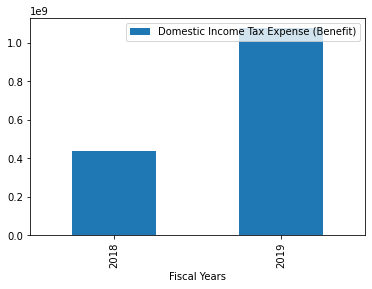

In [257]:
data_hist.plot.bar(x='Fiscal Years',y=hvar)


In [253]:
trend = alt.Chart(data_hist,width=600, height=200).mark_line().encode(
    y=alt.Y(f'{hvar}:Q',scale=alt.Scale(type='linear')),
    x = alt.X(f'{hy}:N')
)
trend


alt.Chart(...)

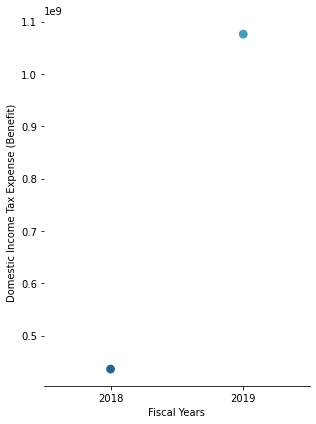

In [261]:
import seaborn as sns

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x=hy, y=hvar,
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=data_hist)
g.despine(left=True)

,Revenues,hist_match,name,sic,yearc,Fiscal Years,Trendline value
year,,,,,,,
2017,1.778660e+11,True,AMAZON COM INC,5961.0,2017,2017,"$177,866,000,000"
2018,2.328870e+11,True,AMAZON COM INC,5961.0,2018,2018,"$232,887,000,000"
2019,2.805220e+11,True,AMAZON COM INC,5961.0,2019,2019,"$280,522,000,000"


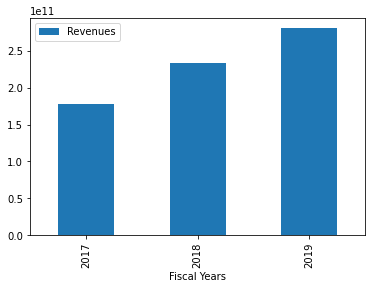

In [406]:
# Load necessary files:
t=dill.load(open('t.pkl','rb'))
tag2label=dill.load(open('tag2label.pkl','rb'))
tickers=pd.read_table('tickers.txt')
tickers=tickers.set_index('cik')


# Get request to read in form entries
years=[2017,2018,2019,2020]
histnum='Revenues'
#histnum='EffectiveIncomeTaxRateReconciliationTaxCredits'
histbase=None
tic='amzn' 

# Chart build-up
setselect=(t.index.get_level_values('year').isin(years) & (t.index.get_level_values('cik')==ticik))

# Create dataset to be charted
if histbase!=None:
    data_hist=t.loc[setselect,[('value',histnum),('value',histbase),('month',histnum),('month',histbase)]].copy()
    data_hist[('','hist_match')]=(t[('month',histnum)]==t[('month',histbase)])
    data_hist=data_hist.drop([('month',histnum),('month',histbase)],axis=1)    
if histbase==None:
    data_hist=t.loc[setselect,list(set([('value',histnum),('month',histnum)]))].copy()
    data_hist[('','hist_match')]=t[('month',histnum)].notnull()
    data_hist=data_hist.drop([('month',histnum)],axis=1)

# Drop 0 level and add company name:
data_hist=data_hist.droplevel(axis=1,level=0)
data_hist=data_hist.merge(dill.load(open('sic_codes.pkl','rb')),how='left',left_index=True,right_index=True)
data_hist=data_hist.droplevel(axis=0,level=0)

# Define variables to be charted:
h1=tag2label[histnum]
if histbase!=None:
    h2=tag2label[histbase]
hy='Fiscal Years'
if histbase!=None:
    hvar=h1+' Per '+h2
else:
    hvar=h1
data_hist.loc[data_hist['hist_match'],h1]=data_hist[histnum]
if histbase!=None:
    data_hist.loc[data_hist['hist_match'],h2]=data_hist[histbase]
data_hist['yearc']=data_hist.index.get_level_values('year').astype('str')
data_hist.loc[data_hist['hist_match'],hy]=data_hist['yearc']

# Sort years:
data_hist=data_hist.sort_values('year',ascending=True)

#Define trendline variable:
if histbase!=None:
    data_hist[hvar]=data_hist[h1]/data_hist[h2]
else:
    data_hist[hvar]=data_hist[h1]
data_hist.loc[data_hist['hist_match']==0,hvar]=None

#Add string formatted labels:
hvarlabel='Trendline value'
if histbase!=None:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "{:,.2f}".format(x))
elif data_hist[hvar].mean()>1:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x: "${:,.0f}".format(x))
else:
    data_hist[hvarlabel]=data_hist[hvar].map(lambda x:100*x).map(lambda x: "{:,.2f}%".format(x))

trend=data_hist.plot.bar(x=hy,y=hvar)
data_hist

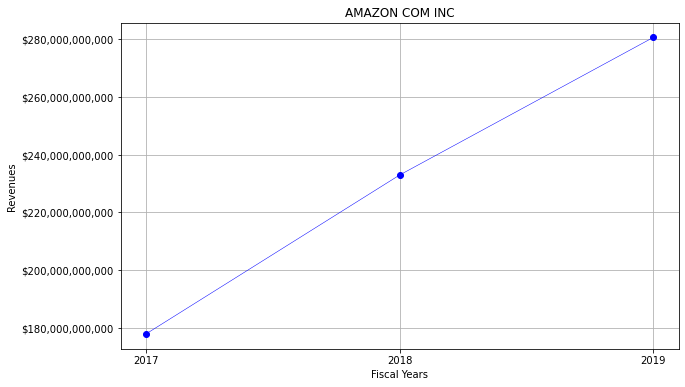

In [407]:
if (histbase==None) & (data_hist[hvar].mean()<=1):
    data_hist[hvar]=data_hist[hvar].map(lambda x:100*x)
    perc=True
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(hy,hvar,'b-',marker='o',lw=0.5,data=data_hist)
plt.ylabel(hvar)
plt.xlabel(hy)
plt.grid(True)
plt.title(data_hist['name'].values[0])

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
if histbase!=None:
    plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in current_values])
elif perc==True:
    plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in current_values])
    perc=None
else:
    plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])
plt.show()


AttributeError: 'list' object has no attribute 'save'

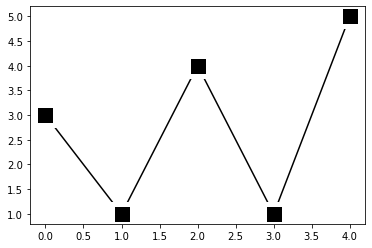

In [388]:
import matplotlib.pyplot as plt, mpld3
fig=plt.plot([3,1,4,1,5], 'ks-', mec='w', mew=5, ms=20)
fig.save

In [367]:
data_hist[hvarlabel].values

array(['$177,866,000,000', '$232,887,000,000', '$280,522,000,000'],
      dtype=object)

In [363]:
data_hist

,Revenues,hist_match,name,sic,yearc,Fiscal Years,Trendline value
year,,,,,,,
2017,1.778660e+11,True,AMAZON COM INC,5961.0,2017,2017,"$177,866,000,000"
2018,2.328870e+11,True,AMAZON COM INC,5961.0,2018,2018,"$232,887,000,000"
2019,2.805220e+11,True,AMAZON COM INC,5961.0,2019,2019,"$280,522,000,000"


In [410]:
l=['All Available','4','5']
if l.index('All Available'):
    l.pop(l.index('All Available'))
l

['4', '5']

In [412]:
if l.index('45'):
    g=True

ValueError: '45' is not in list

In [413]:
g

In [425]:
yearlist=None
if yearlist:
    if (yearlist[0]=='All Available'):
        years=[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
    else:
        years=[int(y) for y in yearlist] 

In [442]:
# Get request to read in form entries
yearlist = None
if yearlist:
    if yearlist[0]=='All Available':
        years=[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
    else:
        years=[int(y) for y in yearlist]       


In [444]:
yearlist=[]
if yearlist:
    if 2<3:
        years=[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

In [445]:
years

[2011, 2010]

In [447]:
if 'gog' in None:
    print('hh')

TypeError: argument of type 'NoneType' is not iterable